In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
import glob
import aplpy
import sqlite3 
import gzip 
import io
import os

import copy
import json

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [76]:
def show_stamps(ztf_object_id, im_dir):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    
    fig = plt.figure(figsize=(12,4))
    dirs = glob.glob(f"{im_dir}{ztf_object_id}*.fits")

    for i, cutout in enumerate(['Science','Template','Difference']):
        fits_dir = [x for x in dirs if cutout in x][0]
        ffig = plot_cutout(fits_dir, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)
    fig.show()

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 50

# Set important constants

In [3]:
day_thres = 10 # days
now_jd = Time.now().jd
now_utc = Time.now()

## ***For today, let now_jd be 20 days ago

In [4]:
offset = 0 #days
now_jd -= offset

# Connect to database

In [5]:
conn = sqlite3.connect('../local/db/sqlite_pid2.db')
cutout_dir = '../local/cutouts/'

# Quick look at objects seen

In [6]:
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']

In [7]:
df.loc[df['SIMBAD_include'] == 1]

,ztf_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
2,ZTF18acctenq,EB*,45.502164,23.766712,2RXS J030200.8+234606,1.0,2.459271e+06,NaN,NaN,None
3233,ZTF18abjgxsf,EB*,338.947888,18.311449,2RXS J223549.6+181804,1.0,NaN,NaN,NaN,None
3247,ZTF18abcoxqh,*,336.034493,17.479413,2RXS J222408.0+172903,1.0,NaN,NaN,NaN,None
3261,ZTF19acvugzy,PM*,49.917256,23.909945,2RXS J031938.6+235453,1.0,2.459275e+06,NaN,NaN,None
3262,ZTF18acbvqqk,*,47.705896,19.753105,2RXS J031048.3+194518,1.0,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...
15616,ZTF18acnbdzh,*,133.248276,25.888988,2RXS J085300.5+255254,1.0,2.459297e+06,0.0,1.0,None
15617,ZTF19aadldxm,Ro*,128.880817,-9.071567,2RXS J083531.5-090409,1.0,2.459297e+06,0.0,1.0,None
15620,ZTF17aaajfkg,PM*,145.538695,33.777481,2RXS J094209.4+334637,1.0,2.459297e+06,0.0,1.0,None
15623,ZTF20aasyqox,X,146.066573,-21.278110,2RXS J094413.6-211638,1.0,2.459297e+06,0.0,1.0,None


# Read lightcurve data

In [8]:
cur = conn.cursor()
cur.execute("SELECT * FROM lightcurves")
dflc = pd.DataFrame(cur.fetchall())
dflc.columns = ['ztf_object_id', 'jd', 'fid', 'magpsf', 'sigmapsf', 'diffmaglim', 'isdiffpos', 'magnr', 'sigmagnr', 'field', 'rcid']
dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']] = dflc[['jd', 'magpsf', 'sigmapsf', 'diffmaglim', 'magnr', 'sigmagnr', 'field', 'rcid']].astype(float)
dflc['fid'] = dflc['fid'].astype(int)

## ***For today, drop all rows taken after "now_jd"

In [9]:
dflc = dflc.loc[(now_jd - dflc['jd']) > 0]

<AxesSubplot:>

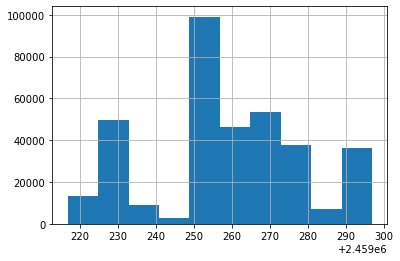

In [10]:
dflc['jd'].hist()

# Preprocess lightcurve data

### Impute missing magnr and sigmagnr

In [11]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.6404264563161577

In [12]:
len(dflc['field'].dropna()) / len(dflc['field'])

0.28769156115286526

In [13]:
len(dflc['rcid'].dropna()) / len(dflc['rcid'])

0.28769156115286526

In [14]:
grp = dflc.groupby(['fid','field','rcid'])
impute_magnr = grp['magnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_magnr)
impute_sigmagnr = grp['sigmagnr'].agg(lambda x: np.median(x[np.isfinite(x)]))
# print(impute_sigmagnr)

In [15]:
for idx, grpi in grp:
    w = np.isnan(grpi['magnr'])
    w2 = grpi[w].index
    dflc.loc[w2,'magnr'] = impute_magnr[idx]
    dflc.loc[w2,'sigmagnr'] = impute_sigmagnr[idx]

In [16]:
len(dflc['magnr'].dropna()) / len(dflc['magnr'])

0.7100401742388336

### Calculate DC magnitude

In [17]:
dflc['sign'] = 2* (dflc['isdiffpos'] == 't') - 1
dflc['sign']

0         1
1        -1
2         1
3        -1
4         1
         ..
354451   -1
354452    1
354453   -1
354454   -1
354455   -1
Name: sign, Length: 354456, dtype: int32

In [18]:
u = 10**(-0.4*dflc['magnr']) + dflc['sign'] * 10**(-0.4*dflc['magpsf'])
dflc['dc_mag'] = -2.5 * np.log10(u)
dflc['dc_sigmag'] = np.sqrt(
    (10**(-0.4*dflc['magnr'])* dflc['sigmagnr']) **2. + 
    (10**(-0.4*dflc['magpsf']) * dflc['sigmapsf'])**2.) / u
dflc['dc_mag_ulim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) + 10**(-0.4*dflc['diffmaglim']))
dflc['dc_mag_llim'] = -2.5 * np.log10(10**(-0.4*dflc['magnr']) - 10**(-0.4*dflc['diffmaglim']))

In [19]:
dflc.sign.dropna()

0         1
1        -1
2         1
3        -1
4         1
         ..
354451   -1
354452    1
354453   -1
354454   -1
354455   -1
Name: sign, Length: 354456, dtype: int32

### Drop 0.5% of most uncertain obs

In [20]:
thres = dflc['dc_sigmag'].quantile(.995)
dflc = dflc.loc[~(dflc['dc_sigmag'] > thres)]

### Create new column with ulims subsituting nan dc_mag

In [21]:
dflc['combined_mag_ulim'] = [dflc.loc[ii, 'dc_mag_ulim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

In [22]:
dflc['combined_mag_ulim'].dropna()

0         14.186017
2         13.044404
4         14.251781
6         14.136993
7         13.050532
            ...    
354451    17.704599
354452    17.962109
354453    18.755692
354454    17.345358
354455    16.080498
Name: combined_mag_ulim, Length: 250542, dtype: float64

In [23]:
# dflc['combined_mag_ulim'] = [dflc.loc[ii, 'diffmaglim'] if pd.isna(dflc.loc[ii, 'dc_mag']) else dflc.loc[ii, 'dc_mag'] for ii in dflc.index]

### Exclude objects with otypes we are not interested in

In [24]:
# interest = df.loc[df['SIMBAD_include'] == 1]
# mask = [x in interest['ztf_object_id'].values for x in dflc['ztf_object_id']]
# dflc_interest = dflc.loc[mask]


In [53]:
dflc_interest = dflc[dflc['ztf_object_id'].isin(df.loc[df['SIMBAD_include'] == 1, 'ztf_object_id'])]
dflc_interest

,ztf_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid,sign,dc_mag,dc_sigmag,dc_mag_ulim,dc_mag_llim,combined_mag_ulim
73,ZTF18acctenq,2.459244e+06,1,16.670269,0.090340,19.074606,t,13.162000,0.020,NaN,NaN,1,13.119929,0.019544,13.157325,13.166695,13.119929
74,ZTF18acctenq,2.459217e+06,1,NaN,NaN,20.016701,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
75,ZTF18acctenq,2.459217e+06,2,NaN,NaN,19.739599,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
76,ZTF18acctenq,2.459219e+06,2,NaN,NaN,20.292500,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
77,ZTF18acctenq,2.459219e+06,1,NaN,NaN,20.721201,None,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354355,ZTF18aakehkl,2.459292e+06,1,NaN,NaN,20.544901,None,18.257999,0.033,791.0,18.0,-1,NaN,NaN,18.133321,18.398874,18.133321
354356,ZTF18aakehkl,2.459292e+06,2,NaN,NaN,20.427000,None,16.176500,0.030,791.0,18.0,-1,NaN,NaN,16.155060,16.198372,16.155060
354357,ZTF18aakehkl,2.459294e+06,2,NaN,NaN,20.395599,None,16.176500,0.030,791.0,18.0,-1,NaN,NaN,16.154437,16.199021,16.154437
354358,ZTF18aakehkl,2.459297e+06,1,NaN,NaN,19.835800,None,18.257999,0.033,791.0,18.0,-1,NaN,NaN,18.029871,18.547171,18.029871


In [54]:
dflc_interest[['dc_mag', 'dc_mag_ulim']].dropna(how='all')

,dc_mag,dc_mag_ulim
73,13.119929,13.157325
82,13.217732,13.160309
87,13.328526,13.161006
89,13.335475,13.160890
853,13.180293,13.292045
...,...,...
354355,NaN,18.133321
354356,NaN,16.155060
354357,NaN,16.154437
354358,NaN,18.029871


In [55]:
dflc_interest[['dc_mag', 'dc_mag_ulim', 'combined_mag_ulim']]

,dc_mag,dc_mag_ulim,combined_mag_ulim
73,13.119929,13.157325,13.119929
74,NaN,NaN,NaN
75,NaN,NaN,NaN
76,NaN,NaN,NaN
77,NaN,NaN,NaN
...,...,...,...
354355,NaN,18.133321,18.133321
354356,NaN,16.155060,16.155060
354357,NaN,16.154437,16.154437
354358,NaN,18.029871,18.029871


### Set df index to id and filter, then sort by time

In [56]:
# len(dflc_interest['ztf_object_id'].unique())

dflc_interest['utc'] = pd.to_datetime(dflc_interest['jd'], unit='D', origin='julian')
dflc_interest.set_index(['ztf_object_id', 'fid'], inplace=True)
dflc_interest = dflc_interest.sort_values('utc').sort_index()

### Get list of ids seen in the past X days

In [57]:
last_seen = dflc_interest.groupby('ztf_object_id')['jd'].max()
new_sources = last_seen.loc[(now_jd - last_seen) < day_thres].index

In [58]:
print(f"Number of new sources: {len(new_sources)}")

Number of new sources: 147


### Calculate exponential weighted moving averages
using timescales of 2, 8, and 28 days

In [59]:
# dflc_interest['ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["dc_mag"].ewm(halflife='28 days', times=x['utc']).mean()).values

In [32]:
# dflc_interest['combined_ema2'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='2 days', times=x['utc']).mean()).values
dflc_interest['combined_ema8'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='8 days', times=x['utc']).mean()).values
# dflc_interest['combined_ema28'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ulim"].ewm(halflife='28 days', times=x['utc']).mean()).values

### Calculate our metric for outbursting

- Take difference between 8day halflife EWMA and dc_magnitude
- Take the 4 day halflife EWMA of these differences

In [60]:
dflc_interest['mag_ewm_diff8'] = dflc_interest['dc_mag'] - dflc_interest['ema8']
dflc_interest['mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

In [34]:
dflc_interest['combined_mag_ewm_diff8'] = dflc_interest['combined_mag_ulim'] - dflc_interest['combined_ema8']
dflc_interest['combined_mag_ewm_diff8_rolling4'] = dflc_interest.groupby(["ztf_object_id", "fid"]).apply(lambda x: x["combined_mag_ewm_diff8"].ewm(halflife='4 days', times=x['utc']).mean()).values

### Get data for new sources only and time range we care about 

In [61]:
dflc_interest_new = dflc_interest.loc[new_sources]

In [62]:
ndays_thres = 30
dflc_interest_new = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < ndays_thres]

### Sort our data by max abs magnitude of our metric in the past X day

In [63]:
recent = dflc_interest_new.loc[(now_jd - dflc_interest_new['jd']) < day_thres]
order_by_max = recent.groupby("ztf_object_id")['mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

# Visualize results

In [71]:
from plotting_helpers import plot_dc_lightcurve, plot_dc_lightcurve_lim, mark_seen, show_stamps, plot_cutout, update_value

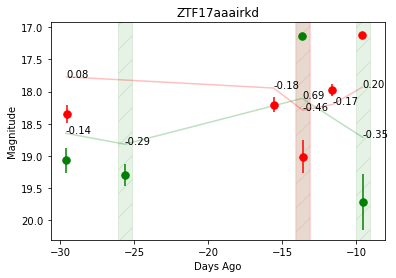

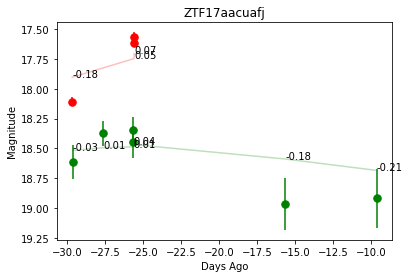

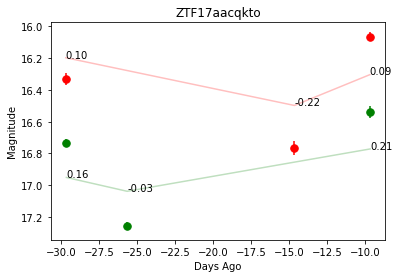

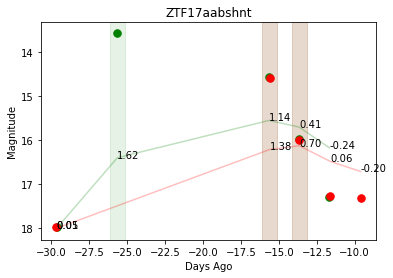

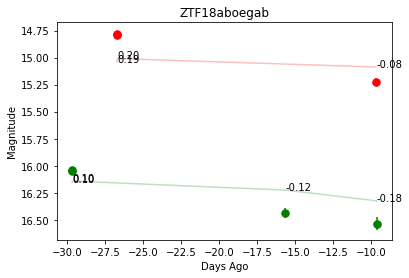

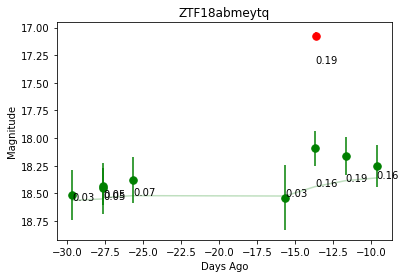

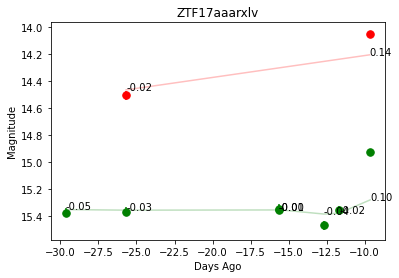

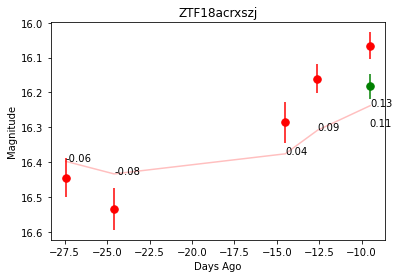

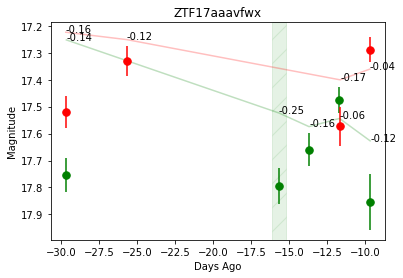

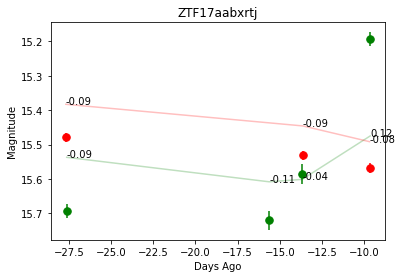

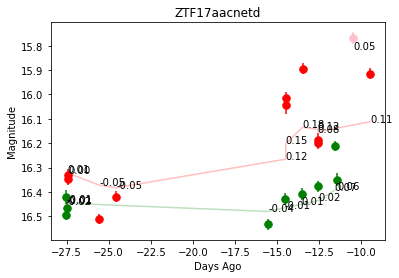

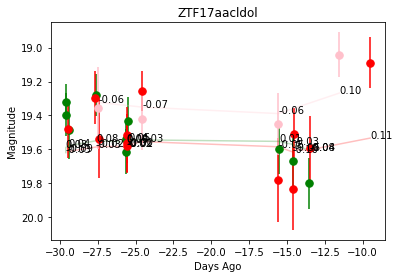

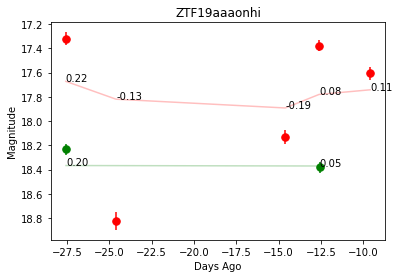

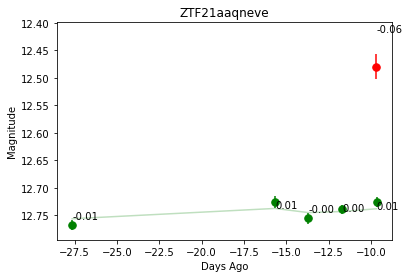

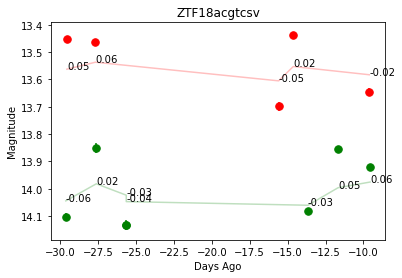

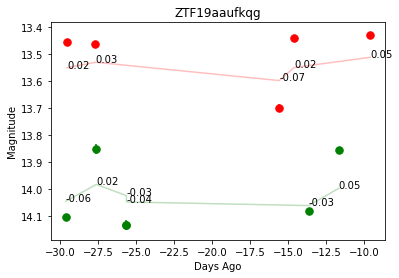

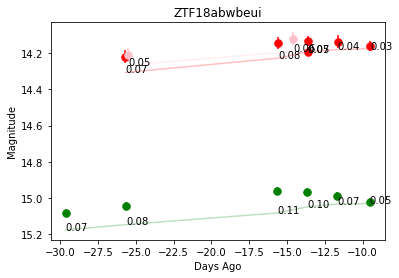

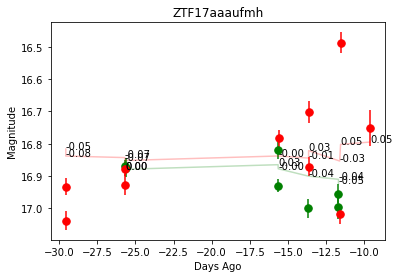

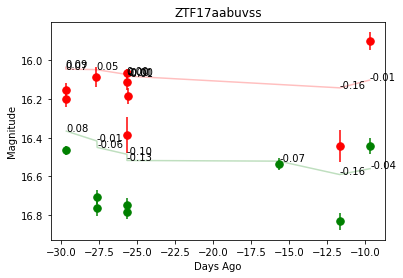

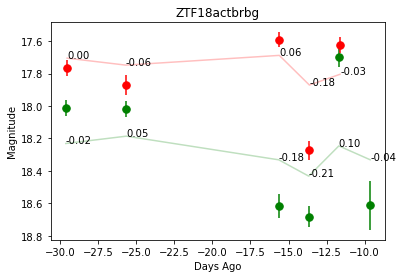

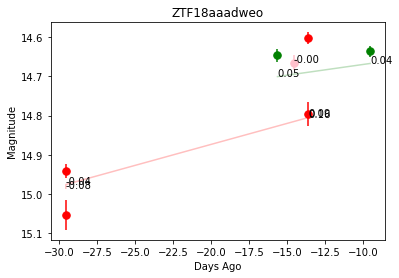

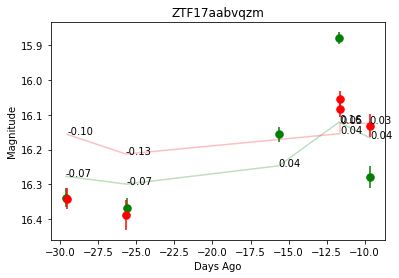

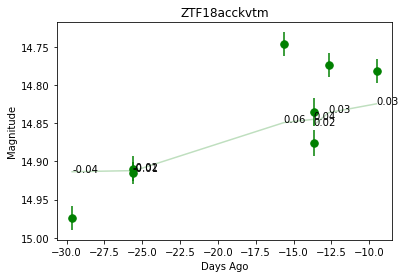

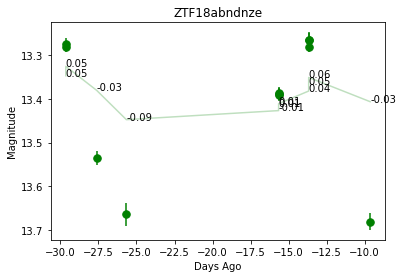

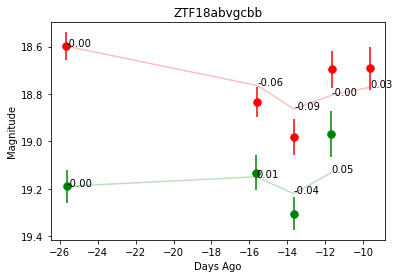

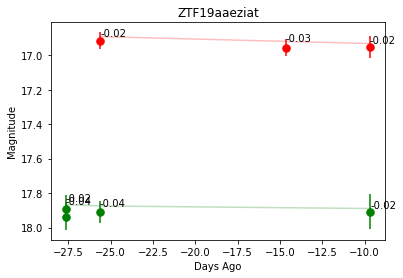

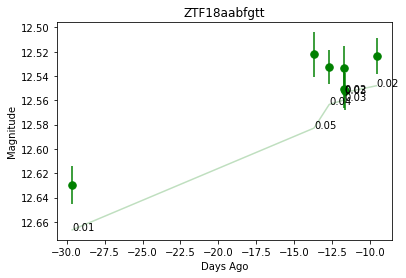

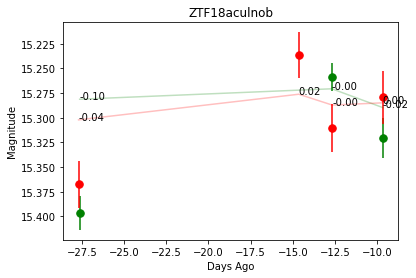

In [65]:
for x in order_by_max[:50]:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag'])
    if len(sub) > 5:
        _ = plot_dc_lightcurve(sub.reset_index(), x, ema='ema8', ema_diff='mag_ewm_diff8_rolling4', offset=offset)
        # show_stamps(x)
    # mark_seen(conn, x)

In [42]:
data = pd.read_csv('../local/AP26145992.csv')
data.head()

,hjd,camera,filter,mag,mag err,flux (mJy),flux err
0,2.457851e+06,be,V,12.372,0.02,43.144,0.794
1,2.456859e+06,be,V,12.416,0.02,41.432,0.762
2,2.458332e+06,be,V,12.395,0.02,42.245,0.777
3,2.457959e+06,be,V,12.383,0.02,42.742,0.786
4,2.458307e+06,be,V,12.412,0.02,41.592,0.765


### Do the same, but now include dc_mag_ulim into the rolling calculations

In [44]:
combined_order_by_max = recent.groupby("ztf_object_id")['combined_mag_ewm_diff8_rolling4'].apply(lambda x: x.abs().max()).sort_values(ascending=False).index

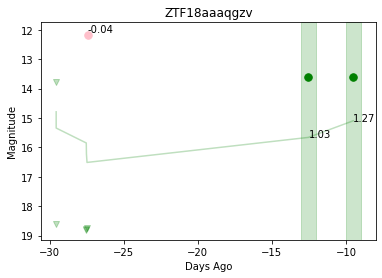

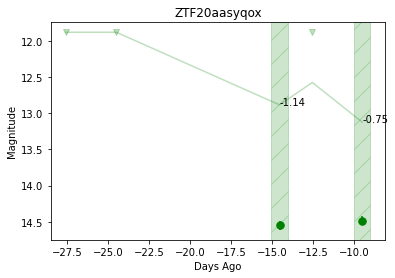

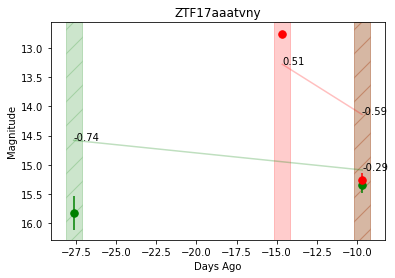

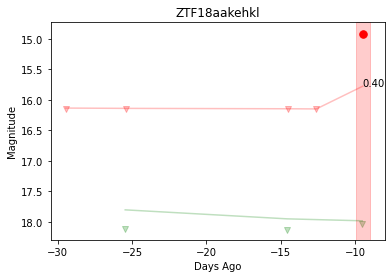

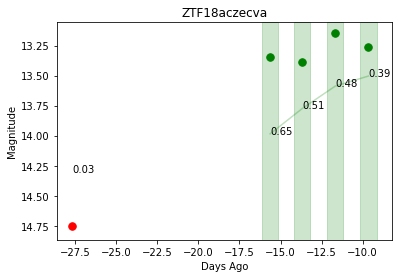

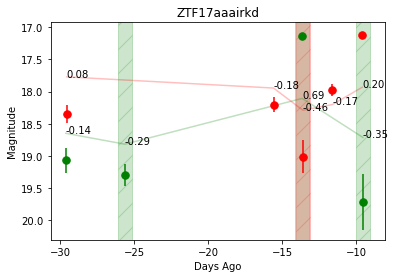

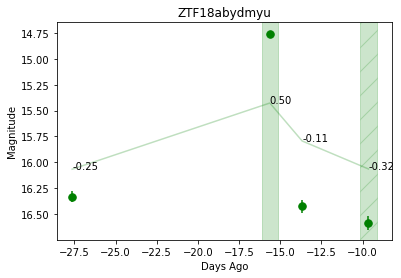

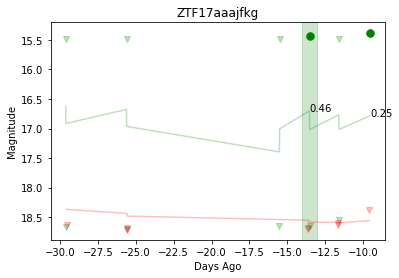

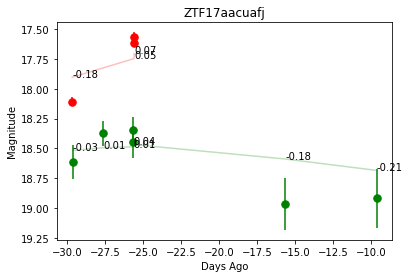

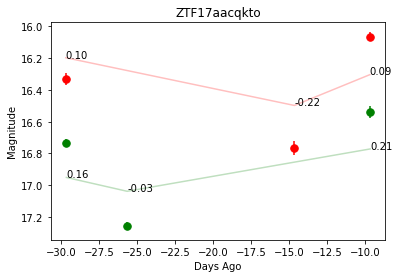

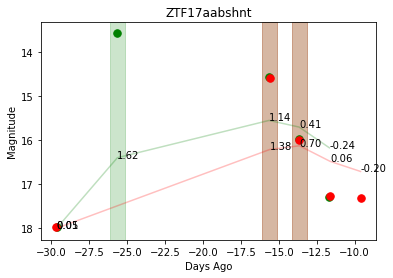

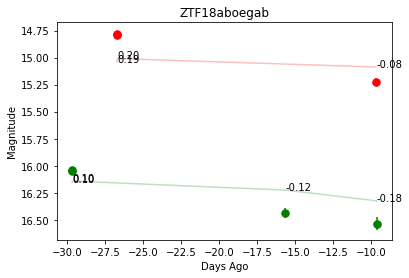

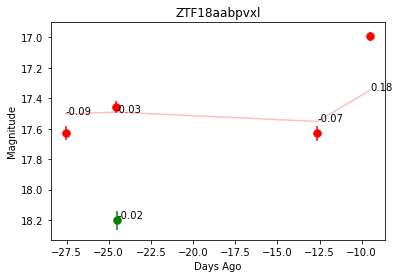

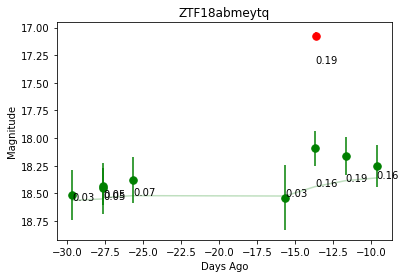

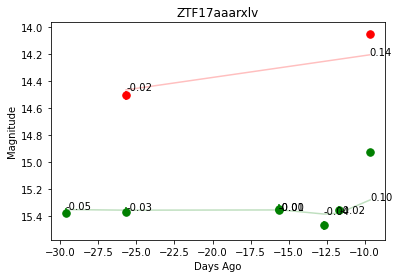

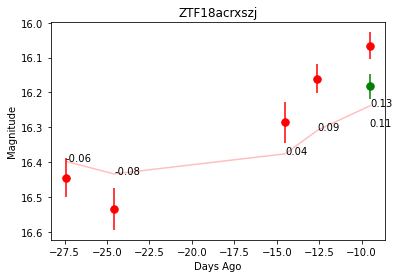

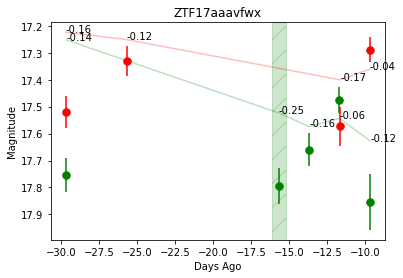

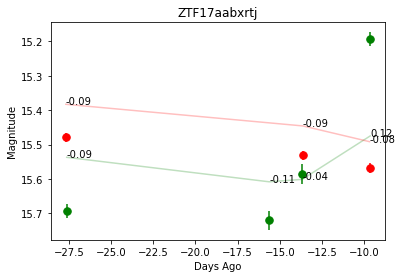

In [45]:
for x in combined_order_by_max[:20]:
    sub = dflc_interest_new.loc[x].dropna(subset=['dc_mag_ulim'])
    if len(sub) > 3:
        plot_dc_lightcurve_lim(sub.reset_index(), x, ema='combined_ema8', ema_diff='combined_mag_ewm_diff8_rolling4', offset=offset)
    # mark_seen(conn, x)
    # show_stamps(x)

## Set up panels

In [87]:
def show_stamps(ztf_object_id, im_dir, show=False):
    # fig, axes = plt.subplots(1,3, figsize=(12,4))
    
    fig = plt.figure(figsize=(12,4))
    dirs = glob.glob(f"{im_dir}{ztf_object_id}*.fits")

    for i, cutout in enumerate(['Science','Template','Difference']):
        fits_dir = [x for x in dirs if cutout in x][0]
        ffig = plot_cutout(fits_dir, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)
    if show:
        fig.show()
    return fig

In [88]:
import panel as pn
pn.extension()

def create_alert_panel(conn, data, ztf_object_id, im_dir, plot_lc_kwargs):
    lc_plot = plot_dc_lightcurve(data, ztf_object_id, **plot_lc_kwargs)
    stamps = show_stamps('ZTF18aabefzb', im_dir)
    
    mark_seen = pn.widgets.Toggle(name='Mark Seen', value=True)
    mark_interest = pn.widgets.Toggle(name='Mark Interest')
    
    notes = pn.widgets.TextInput(value='Notes', width=750)
    
    def b(event):
        if notes.value == 'Notes':
            notes = '""'
        else:
            notes = f'"{notes}"'
        data_to_update = {"seen_flag": mark_seen.value, "interest_flag": mark_interest.value,
                  "notes": notes}
        update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')
    submit = pn.widgets.Button(name='Submit', color='danger')
    submit.on_click(b)
    
    test_panel = pn.Column(pn.Row(f'#{ztf_object_id}', align='center'), 
                           pn.Row(lc_plot, align='center'),
                           pn.Row(mark_seen, mark_interest, align='center'),
                           pn.Row(stamps),
                           pn.Row(notes, align='center'),
                           pn.Row(submit, align='center'))
    return test_panel

INFO: Auto-setting vmin to  1.786e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.030e+02 [aplpy.core]
INFO: Auto-setting vmin to  1.937e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.563e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.158e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.694e+01 [aplpy.core]


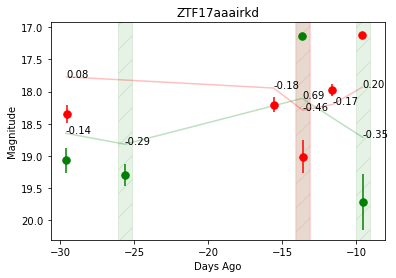

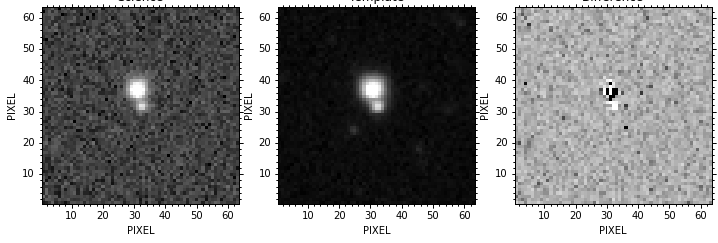

In [89]:
plot_lc_kwargs = {'ema': 'ema8', 'ema_diff': 'mag_ewm_diff8_rolling4', 'offset':offset, 'show':False}
ztf_object_id = 'ZTF17aaairkd'
test = create_alert_panel(conn, dflc_interest_new.loc[ztf_object_id].dropna(subset=['dc_mag']).reset_index(), ztf_object_id, cutout_dir, plot_lc_kwargs)


Traceback (most recent call last):
 File "C:\Users\ykwan\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\panel\viewable.py", line 258, in _on_msg
 patch.apply_to_document(doc, comm.id)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in <lambda>
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 397, in apply_json_patch
 self._trigger_on_message(event_json["msg_type"], event_json["msg_data"])
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 686, in _trigger_on_message
 cb(msg_data)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 355, in apply_json_event
 model._trigger_event(event)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 85, in _trigger_event
 self._document._with_self_as_curdoc(invoke)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 74, in invoke
 callback(event)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\panel\widgets\button.py", line 108, in _server_click
 self._change_event(doc)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\panel\reactive.py", line 204, in _change_event
 self._process_events(events)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\panel\reactive.py", line 187, in _process_events
 self.param.set_param(**self._process_property_change(events))
 File "C:\Users\ykwan\anaconda3\lib\site-packages\param\parameterized.py", line 1472, in set_param
 self_._batch_call_watchers()
 File "C:\Users\ykwan\anaconda3\lib\site-packages\param\parameterized.py", line 1611, in _batch_call_watchers
 self_._execute_watcher(watcher, events)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\param\parameterized.py", line 1573, in _execute_watcher
 watcher.fn(*args, **kwargs)
 File "<ipython-input-88-a256cd3083a1>", line 14, in b
 if notes.value == 'Notes':
UnboundLocalError: local variable 'notes' referenced before assignment
 


 Traceback (most recent call last):
 File "C:\Users\ykwan\anaconda3\lib\site-packages\pyviz_comms\__init__.py", line 325, in _handle_msg
 self._on_msg(msg)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\panel\viewable.py", line 258, in _on_msg
 patch.apply_to_document(doc, comm.id)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in apply_to_document
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 1169, in _with_self_as_curdoc
 return f()
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\protocol\messages\patch_doc.py", line 100, in <lambda>
 doc._with_self_as_curdoc(lambda: doc.apply_json_patch(self.content, setter))
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 397, in apply_json_patch
 self._trigger_on_message(event_json["msg_type"], event_json["msg_data"])
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 686, in _trigger_on_message
 cb(msg_data)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\document\document.py", line 355, in apply_json_event
 model._trigger_event(event)
 File "C:\Users\ykwan\anaconda3\lib\site-packages\bokeh\util\callback_manager.py", line 85, in _trigger_event
 self._do

Column
    [0] Row(align='center')
        [0] Markdown(str)
    [1] Row(align='center')
        [0] Matplotlib(Figure)
    [2] Row(align='center')
        [0] Toggle(name='Mark Seen', value=True)
        [1] Toggle(name='Mark Interest')
    [3] Row
        [0] Matplotlib(Figure)
    [4] Row(align='center')
        [0] TextInput(value='Notes', width=750)
    [5] Row(align='center')
        [0] Button(name='Submit')
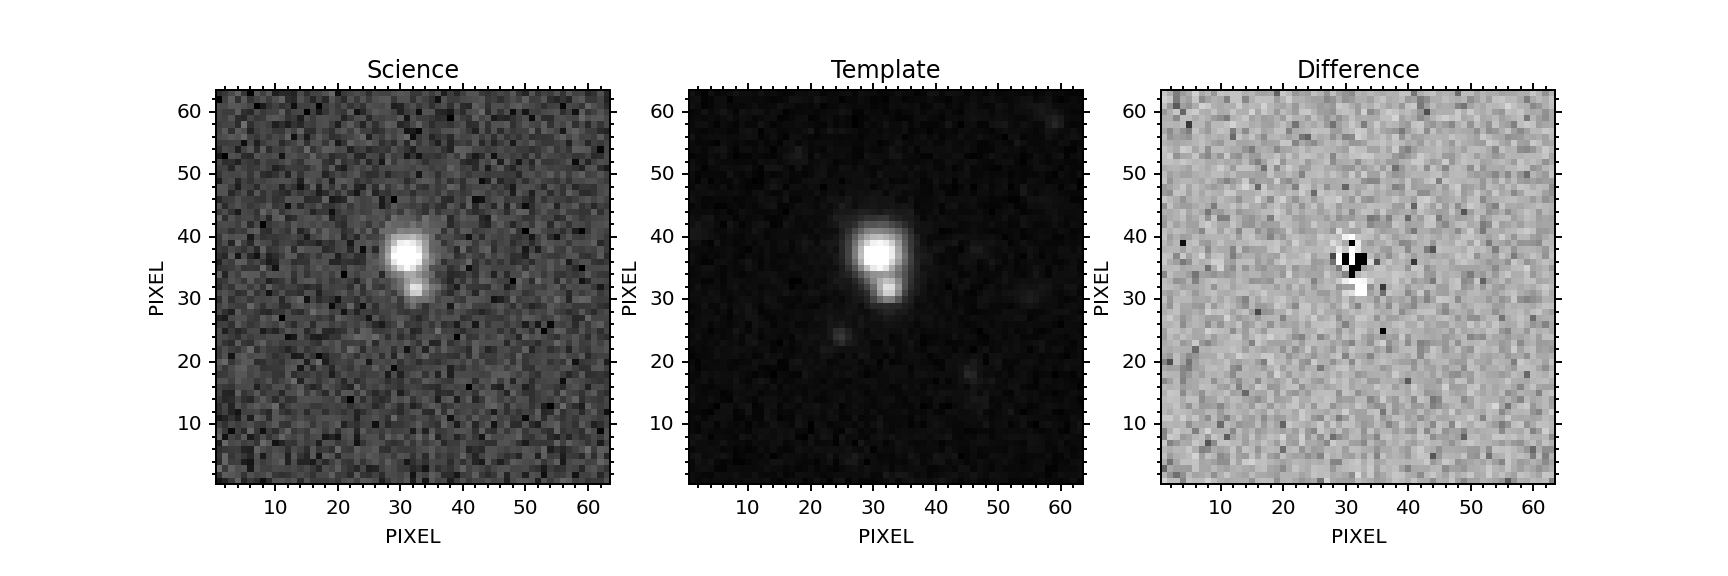
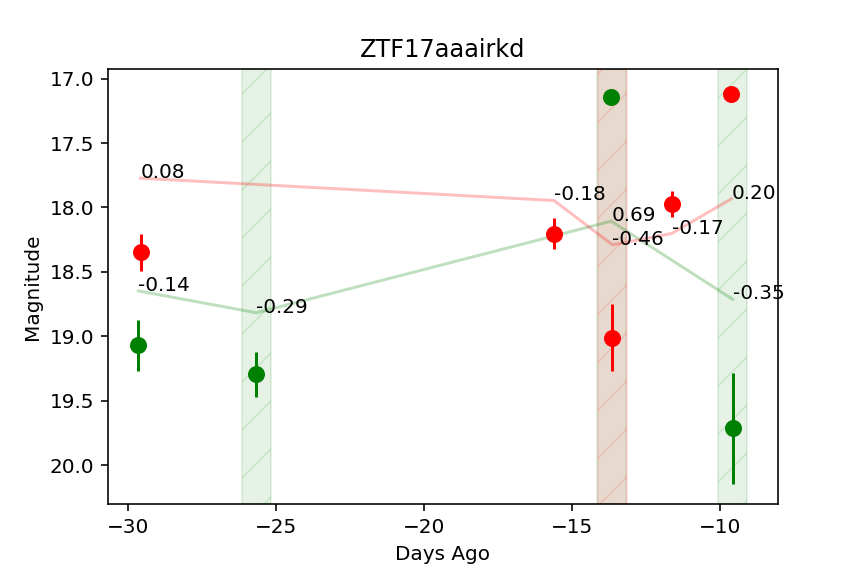

In [90]:
test

### check if updating worked 
not working yet

In [91]:
conn = sqlite3.connect('../local/db/sqlite_pid2.db')
df = pd.read_sql_query("SELECT * FROM ZTF_objects", conn)
df.columns = ['ztf_object_id', 'SIMBAD_otype', 'ra', 'dec', 'ROSAT_IAU_NAME',
       'SIMBAD_include', 'last_obs', 'seen_flag', 'interest_flag', 'notes']
df.query('ztf_object_id == "ZTF18aabefzb"')
df.query('ztf_object_id == "ZTF17aaairkd"')

,ztf_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
4676,ZTF17aaairkd,AM*,106.041859,62.05777,2RXS J070409.2+620329,1.0,2.459297e+06,NaN,NaN,None


In [52]:
# example updating
# data_to_update = {"seen_flag": 1, "interest_flag": 0,
#                   "notes": '"testing"'}
data_to_update = {"seen_flag": 0, "interest_flag": 1,
                  "notes": '""'}
update_value(conn, data_to_update, f'ZTF_object_id = "{ztf_object_id}"')

### Add columns to existing dbs

In [81]:
def add_column(conn, table, col_name, col_type):
    cur = conn.cursor()
    cur.execute(f"ALTER TABLE {table} ADD COLUMN {col_name} {col_type};")
    return pd.read_sql_query(f"SELECT * FROM {table}", conn).dtypes


In [133]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')


In [134]:
add_column(conn_debug, 'ZTF_objects', 'last_obs', 'float')
add_column(conn_debug, 'ZTF_objects', 'seen_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'interest_flag', 'int')
add_column(conn_debug, 'ZTF_objects', 'notes', 'text')

ZTF_object_id      object
SIMBAD_otype       object
ra                float64
dec               float64
ROSAT_IAU_NAME     object
SIMBAD_include    float64
last_obs           object
seen_flag          object
interest_flag      object
notes              object
dtype: object

In [90]:
pd.read_sql_query("SELECT * FROM lightcurves", conn).dtypes

ZTF_object_id     object
jd                object
fid               object
magpsf           float64
sigmapsf         float64
diffmaglim       float64
isdiffpos         object
magnr            float64
sigmagnr         float64
dtype: object

In [182]:
conn_debug = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')

pd.read_sql_query("SELECT * FROM ZTF_objects", conn_debug).dropna(subset=['ra'])

,ZTF_object_id,SIMBAD_otype,ra,dec,ROSAT_IAU_NAME,SIMBAD_include,last_obs,seen_flag,interest_flag,notes
30,ZTF18aabezub,None,40.207699,49.865258,2RXS J024048.8+495203,0.0,2.459270e+06,0.0,0.0,None
31,ZTF18acmysaq,BLL,53.486514,65.615648,2RXS J033357.0+653705,0.0,2.459270e+06,0.0,0.0,None
32,ZTF20aaffcza,None,57.535898,76.662918,2RXS J035011.9+764002,0.0,2.459270e+06,0.0,0.0,None
33,ZTF18absqkfg,G,43.684938,47.442902,2RXS J025444.0+472639,0.0,2.459270e+06,0.0,0.0,None
34,ZTF19abjolmq,None,64.610641,73.275639,2RXS J041824.0+731635,0.0,2.459270e+06,0.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...
336,ZTF18acbzkta,None,63.756536,32.335179,2RXS J041501.6+322002,0.0,2.459270e+06,0.0,0.0,None
337,ZTF18abydmyu,DN*,86.951510,28.586512,2RXS J054748.5+283511,1.0,2.459270e+06,0.0,1.0,None
338,ZTF18achucnm,None,63.549904,36.601002,2RXS J041413.5+363554,0.0,2.459270e+06,0.0,0.0,None
339,ZTF18acdyfgs,QSO,38.043686,32.663463,2RXS J023209.8+323932,0.0,2.459270e+06,0.0,0.0,None


In [84]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitesimple.db')
add_column(cnx, 'lightcurves', 'field', 'int')
add_column(cnx, 'lightcurves', 'rcid', 'int')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF19abceihx,2459218.6020023,1,19.221775,0.175954,19.369980,f,17.524000,0.014,None,None
1,ZTF19abceihx,2459189.6685648,2,19.011000,0.137446,19.469000,f,17.299000,0.018,None,None
2,ZTF19abceihx,2459189.6930556,2,18.864500,0.107180,19.620899,f,17.243000,0.020,None,None
3,ZTF19abceihx,2459192.6256366,2,18.951799,0.252563,18.841499,f,17.299000,0.018,None,None
4,ZTF19abceihx,2459192.627037,2,18.754900,0.192248,18.947001,f,17.243000,0.020,None,None
...,...,...,...,...,...,...,...,...,...,...,...
374540,ZTF18abtoupn,2459274.0565162,2,15.225590,0.020630,18.288145,f,14.506000,0.020,None,None
374541,ZTF18aborthl,2459274.0565162,2,17.907963,0.153364,18.162607,f,16.231001,0.026,None,None
374542,ZTF18abtovjo,2459274.0545486,2,17.512791,0.111764,18.462793,t,16.457001,0.015,None,None
374543,ZTF18absuniq,2459274.0574537,2,17.610895,0.168301,18.063719,t,15.917999,0.016,None,None


In [89]:
cnx = sqlite3.connect('/epyc/users/ykwang/Github/alert_stream_crossmatch/local/db/sqlitedebug.db')
pd.read_sql_query("SELECT * FROM lightcurves", cnx)

,ZTF_object_id,jd,fid,magpsf,sigmapsf,diffmaglim,isdiffpos,magnr,sigmagnr,field,rcid
0,ZTF18aabezub,2459269.6372801,2,18.705532,0.082297,20.220669,f,18.289000,0.020,NaN,NaN
1,ZTF18aabezub,2459248.6617593,2,18.890499,0.094581,20.413300,f,18.289000,0.020,NaN,NaN
2,ZTF18aabezub,2459248.7015972,1,18.811001,0.095207,20.477900,f,18.368999,0.034,NaN,NaN
3,ZTF18aabezub,2459250.6761574,2,18.921400,0.107312,19.907301,f,18.289000,0.020,NaN,NaN
4,ZTF18aabezub,2459250.7026157,1,18.815800,0.110672,20.051100,f,18.368999,0.034,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
40024,ZTF21aanswqf,2459274.0574537,2,NaN,NaN,17.979700,None,NaN,NaN,542.0,20.0
40025,ZTF21aanswqf,2459275.0508449,2,NaN,NaN,18.607500,None,NaN,NaN,542.0,20.0
40026,ZTF21aanswqf,2459275.0532755,2,NaN,NaN,18.440001,None,NaN,NaN,542.0,20.0
40027,ZTF18abtovjo,2459275.0552431,2,17.455315,0.076400,18.567413,t,16.457001,0.015,593.0,31.0
